# Predicción de Concesión de Crédito





Durante este *Notebook* se va a mostrar cuál ha sido el procedimiento que hemos seguido para trabajar con un conjunto de datos que está diseñado para abordar dos problemas en el contexto de la concesión de créditos:

- **Clasificación**: Se utiliza la variable **CreditoAprobado**, que se trata de una variable binaria, para determinar si se concede o no el crédito a un solicitante en función de diversas características personales y financieras. Entre las variables que podrían influir en esta decisión están la edad, ingresos, experiencia laboral, patrimonio neto, la relación entre deuda total e ingresos, entre otros.

- **Regresión**: El dataset también incluye la variable **ScoreRiesgo**, que proporciona una puntuación numérica para evaluar el riesgo asociado a la concesión de crédito. Este score se puede basar en factores como el historial de pagos, estabilidad laboral, ratio deuda/ingresos, entre otros.

## Carga de datos y análisis preliminar

Se cargan los datos desde un archivo CSV, y se muestra información preliminar sobre el tamaño del dataset, las primeras filas, las estadísticas descriptivas, y los valores faltantes.

In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb

In [ ]:
# Cargar los datos del CSV a un DataFrame
df = pd.read_csv("EstudioCrediticio_TrainP.csv")

# Analizar la distribución de algunas variables
# (Reemplaza 'variable_name' con el nombre de la columna que deseas analizar)
# sns.histplot(df['variable_name'])
# plt.show()

# Analizar la correlación entre las variables
# sns.heatmap(df.corr(), annot=True)
# plt.show()

# Puedes agregar más análisis según tus necesidades, por ejemplo:
# - Analizar la relación entre variables categóricas y numéricas.
# - Crear tablas de frecuencia para variables categóricas.
# - Realizar análisis de outliers.
# - Etc.
print(df.shape)

(50000, 36)


- El tamaño del conjunto de datos contiene 50000 individuos con 36 variables que estan relacionadas con su situación económica y personal.

In [ ]:
# Mostrar las primeras 5 filas del DataFrame
df.head(5)

,Id,Edad,IngresoBrutoAnual,ScoreCrediticio,SituacionLaboral,NivelEducativo,Experiencia,CuantiaCredito,DuracionCredito,EstadoCivil,...,IngresoBrutoMensual,HistoricoPagosSuministros,EstabilidadLaboral,PatrimonioNeto,TipoInteresBase,TipoInteres,PagoMensualCredito,RatioTotalDeudaIngresos,CreditoAprobado,ScoreRiesgo
0,1,44,22119,613.0,Empleado/a por cuenta ajena,FP,20.0,16154,60,Divorciado/a,...,1843.250000,0.771340,2,28390,0.179654,0.171628,402.883608,0.483322,0,50.0
1,2,26,28874,582.0,Empleado/a por cuenta ajena,Bachillerato,0.0,11800,24,Divorciado/a,...,2406.166667,NaN,6,115113,0.160800,0.172783,584.997790,0.541524,0,54.0
2,3,38,84154,507.0,Empleado/a por cuenta ajena,Grado universitario,17.0,9257,36,Divorciado/a,...,7012.833333,0.881874,4,41268,0.205757,0.217175,352.177802,0.074460,1,42.4
3,4,51,29464,504.0,Autónomo/a,FP,25.0,5495,36,Divorciado/a,...,2455.333333,0.797217,5,1927,0.203495,0.197683,203.565671,0.246633,1,45.6
4,5,39,20646,542.0,Empleado/a por cuenta ajena,Grado universitario,16.0,14824,60,Soltero/a,...,1720.500000,0.714030,3,10011,0.213824,0.212976,403.524570,0.375196,0,61.0


In [ ]:
# Información general sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14465 entries, 0 to 14464
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             14465 non-null  int64  
 1   Edad                           14465 non-null  int64  
 2   IngresoBrutoAnual              14465 non-null  int64  
 3   ScoreCrediticio                13758 non-null  float64
 4   SituacionLaboral               14465 non-null  object 
 5   NivelEducativo                 13000 non-null  object 
 6   Experiencia                    10710 non-null  float64
 7   CuantiaCredito                 14465 non-null  int64  
 8   DuracionCredito                14465 non-null  int64  
 9   EstadoCivil                    11231 non-null  object 
 10  NumeroPersonasDependientes     12746 non-null  float64
 11  EstadoVivienda                 14465 non-null  object 
 12  PagoMensualDeuda               14465 non-null 

- Se puede ver que existen 5 variables de tipo categórico, 19 de tipo entero y 12 variables de tipo decimal.

In [ ]:
# Estadísticas descriptivas de las variables numéricas
df.describe()

,Id,Edad,IngresoBrutoAnual,ScoreCrediticio,Experiencia,CuantiaCredito,DuracionCredito,NumeroPersonasDependientes,PagoMensualDeuda,TasaUtilizacionTarjetaCredito,...,IngresoBrutoMensual,HistoricoPagosSuministros,EstabilidadLaboral,PatrimonioNeto,TipoInteresBase,TipoInteres,PagoMensualCredito,RatioTotalDeudaIngresos,CreditoAprobado,ScoreRiesgo
count,50000.000000,50000.000000,50000.000000,47500.000000,37000.000000,50000.000000,50000.000000,44000.000000,50000.000000,50000.000000,...,50000.000000,41500.000000,50000.00000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,39.757580,36386.727360,570.975347,17.447459,15219.269420,53.716560,1.539386,457.805840,0.285653,...,3009.648663,0.799806,4.99354,7.472013e+04,0.194503,0.194582,519.574152,0.439196,0.293240,50.742756
std,14433.901067,11.606172,24526.447116,51.732132,11.280861,8102.208893,24.630848,1.393505,245.646956,0.159963,...,2014.586218,0.120928,2.22108,1.295051e+05,0.034073,0.039081,385.750819,0.311938,0.455252,7.918796
min,1.000000,18.000000,15000.000000,358.000000,0.000000,1517.000000,12.000000,0.000000,50.000000,0.001204,...,1250.000000,0.217950,0.00000,1.000000e+03,0.088792,0.083259,44.093087,0.017110,0.000000,26.400000
25%,12500.750000,32.000000,19276.500000,539.000000,9.000000,9616.000000,36.000000,0.000000,287.000000,0.161648,...,1596.958333,0.726844,3.00000,8.580000e+03,0.170016,0.166589,280.615934,0.219170,0.000000,44.800000
50%,25000.500000,40.000000,29379.000000,578.000000,17.000000,13427.000000,48.000000,1.000000,402.000000,0.262764,...,2435.416667,0.820477,5.00000,3.280800e+04,0.191688,0.190946,414.927762,0.360822,0.000000,52.000000
75%,37500.250000,48.000000,44947.750000,609.000000,25.000000,18805.250000,60.000000,3.000000,566.000000,0.389237,...,3720.750000,0.892515,6.00000,9.012050e+04,0.216305,0.218748,626.940786,0.571029,1.000000,56.000000
max,50000.000000,80.000000,300000.000000,714.000000,62.000000,116887.000000,120.000000,5.000000,3332.000000,0.946886,...,25000.000000,0.999603,16.00000,6.526980e+06,0.352866,0.378914,6343.673199,4.961286,1.000000,81.000000


In [ ]:
# Contar los valores faltantes por columna
print("Número de valores Null por variable en el conjunto de datos:\n",df.isnull().sum())
print()
print("Número total de valores Null en el conjunto de datos:", df.isnull().sum().sum())

Número de valores Null por variable en el conjunto de datos:
 Edad                                0
IngresoBrutoAnual                   0
ScoreCrediticio                   707
SituacionLaboral                    0
NivelEducativo                   1465
Experiencia                      3755
CuantiaCredito                      0
DuracionCredito                     0
EstadoCivil                      3234
NumeroPersonasDependientes       1719
EstadoVivienda                      0
PagoMensualDeuda                    0
TasaUtilizacionTarjetaCredito       0
NumeroLineasCreditoAbiertas         0
NumeroSolicitudesCredito            0
RatioDeudaIngresos                  0
HistoricoInsolvencia                0
ObjetoCredito                       0
HistoricoImpagos                    0
HistoricoPagos                      0
DuracionHistoricoCredito            0
BalanceCuentaAhorros                0
BalanceCuentaCorriente              0
TotalActivos                        0
TotalPasivos              

- En la anterior salida podemos apreciar que 6 variables contienen valores nulos, siendo la variable *Experiencia* la que más valores nulos contiene. En el conjunto de datos se tiene un total de 46000 valores nulos.

## Separación de variables de salida y división del conjunto de datos

A continuación, se separan las variables dependientes a predecir en función de su tipo de clasificación, ya sea regresión o clasificación.

- **Regresión:** Variable **ScoreRiesgo**

- **Clasificación:** Variable **CreditoAprobado**

Además, se separa el conjunto de datos en conjunto de entrenamiento (90%) y conjunto de prueba(10%), para poder entrenar y evaluar los modelos.

In [ ]:
from sklearn.model_selection import train_test_split

# Separamos los atributos de salida de los demás
atSalidReg = 'ScoreRiesgo'
atSalidClf = 'CreditoAprobado'
df = df.drop(columns=['Id'])
X = df.drop([atSalidReg, atSalidClf], axis = 1)
y_reg = df[atSalidReg]
y_clf = df[atSalidClf]


# Aquí dividimos el dataset en train y test, como hay dos variables de salida hay que hacer separar ambas, usamos stratify para la y
# de clasificación para mantener la proporción entre clases tanto en train como test.

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.1, random_state=33, stratify=y_clf
)

In [ ]:

columnas = X_train.columns
# Identificar las columnas categóricas basadas en el tipo de dato 'object' o de tipo 'category'
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Crear un diccionario que almacena el número de valores únicos para cada columna categórica
unique_values = {col: X_train[col].nunique() for col in categorical_columns}

# Imprimir los resultados
print("Variables categóricas y sus valores únicos:")
for col, unique_count in unique_values.items():
    print(f"Columna: {col}, Valores únicos: {unique_count}")

Variables categóricas y sus valores únicos:
Columna: SituacionLaboral, Valores únicos: 3
Columna: NivelEducativo, Valores únicos: 5
Columna: EstadoCivil, Valores únicos: 4
Columna: EstadoVivienda, Valores únicos: 4
Columna: ObjetoCredito, Valores únicos: 5


## Preprocesamiento: imputación de valores faltantes y codificación

Se realiza la imputación de valores faltantes mediante imputadores iterativos y KNN, además de codificación de las variables categóricas utilizando codificación ordinal y binaria según la naturaleza de las variables.

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

ordinal_col = ['NivelEducativo']
binary_col = ['EstadoCivil', 'EstadoVivienda', 'ObjetoCredito', 'SituacionLaboral']
ordinal_col_mapping = [{
    "col": "NivelEducativo",
    "mapping": {
        'FP': 1,
        'Bachillerato': 2,
        'Grado universitario': 3,
        'Máster': 4,
        'Doctorado': 5,
    }}]

print(categorical_columns)
# Con esto imputamos los valores faltantes usando diferentes estrategías
preprocesamiento = ColumnTransformer(transformers=[('num', IterativeImputer(initial_strategy='median'), numerical_columns),
('cat', Pipeline(steps=[
            ('ordinal', ce.OrdinalEncoder(cols=ordinal_col, mapping = ordinal_col_mapping)), ## Uso ordinal aqui porque sí que hay una relación de orden
            ('binary',ce.OrdinalEncoder(cols=binary_col)),
            ('knn_impute', KNNImputer()) ## Esto imputa los valores comparando con los 5 vecinos más cercanos (de dafault)
        ]), categorical_columns)])

X_train_full = X_train.copy()
X_test_full = X_test.copy()
X_train_full = preprocesamiento.fit_transform(X_train_full)
X_test_full = preprocesamiento.transform(X_test_full)


Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object')


In [ ]:
print(X_train_full.shape)
print(X_test_full.shape)

(45000, 46)
(5000, 46)


In [ ]:
print("Número de valores Null:\n",np.sum(np.isnan(X_train_full)))
X_train_full = pd.DataFrame(X_train_full, columns=columnas, index=X_train.index)

Número de valores Null:
 0


In [ ]:
X_train_full.head(7)

,Edad,IngresoBrutoAnual,ScoreCrediticio,SituacionLaboral,NivelEducativo,Experiencia,CuantiaCredito,DuracionCredito,EstadoCivil,NumeroPersonasDependientes,...,TotalActivos,TotalPasivos,IngresoBrutoMensual,HistoricoPagosSuministros,EstabilidadLaboral,PatrimonioNeto,TipoInteresBase,TipoInteres,PagoMensualCredito,RatioTotalDeudaIngresos
29873,48.0,74413.0,640.0,28.000000,39160.0,84.0,1.00000,251.0,0.431038,1.0,...,327205.0,0.209160,0.205230,881.968564,0.182705,1.0,2.0,1.0,1.0,1.0
15213,20.0,51365.0,612.0,0.000000,8014.0,48.0,0.00000,441.0,0.430191,4.0,...,480540.0,0.162014,0.164359,228.911995,0.156506,1.0,3.0,5.0,2.0,2.0
10276,32.0,22470.0,613.0,10.266785,12311.0,48.0,3.00000,461.0,0.730769,4.0,...,138473.0,0.165811,0.160613,349.283752,0.432728,2.0,2.0,5.0,1.0,3.0
38275,38.0,60949.0,595.0,16.023481,12341.0,48.0,1.53166,638.0,0.337700,1.0,...,96758.0,0.174841,0.195079,372.313126,0.198916,1.0,1.0,1.0,3.0,4.0
49410,49.0,133506.0,567.0,25.000000,15199.0,36.0,2.00000,559.0,0.218763,2.0,...,27274.0,0.181699,0.166858,539.512117,0.098738,3.0,1.0,2.0,3.0,5.0
49942,37.0,36884.0,606.0,13.000000,8741.0,48.0,1.00000,432.0,0.465266,2.0,...,23980.0,0.165741,0.134255,236.349484,0.217444,1.0,4.0,1.0,3.0,2.0
15557,26.0,15000.0,479.0,5.000000,12894.0,60.0,0.00000,197.0,0.291180,5.0,...,44835.0,0.243394,0.225630,360.257608,0.445806,1.0,3.0,2.0,1.0,2.0


## Análisis de correlaciones y eliminación de variables redundantes


Se procede a calcular la matriz de correlaciones para los datos de entrenamiento, la cual nos ayudará a identificar el grado de relación entre cada par de variables. Si se detecta una correlación alta entre dos variables (valor de correlación mayor a 0.95), se considerara oportuno eliminar estas variables del conjunto de entrenamiento para evitar redundancias.

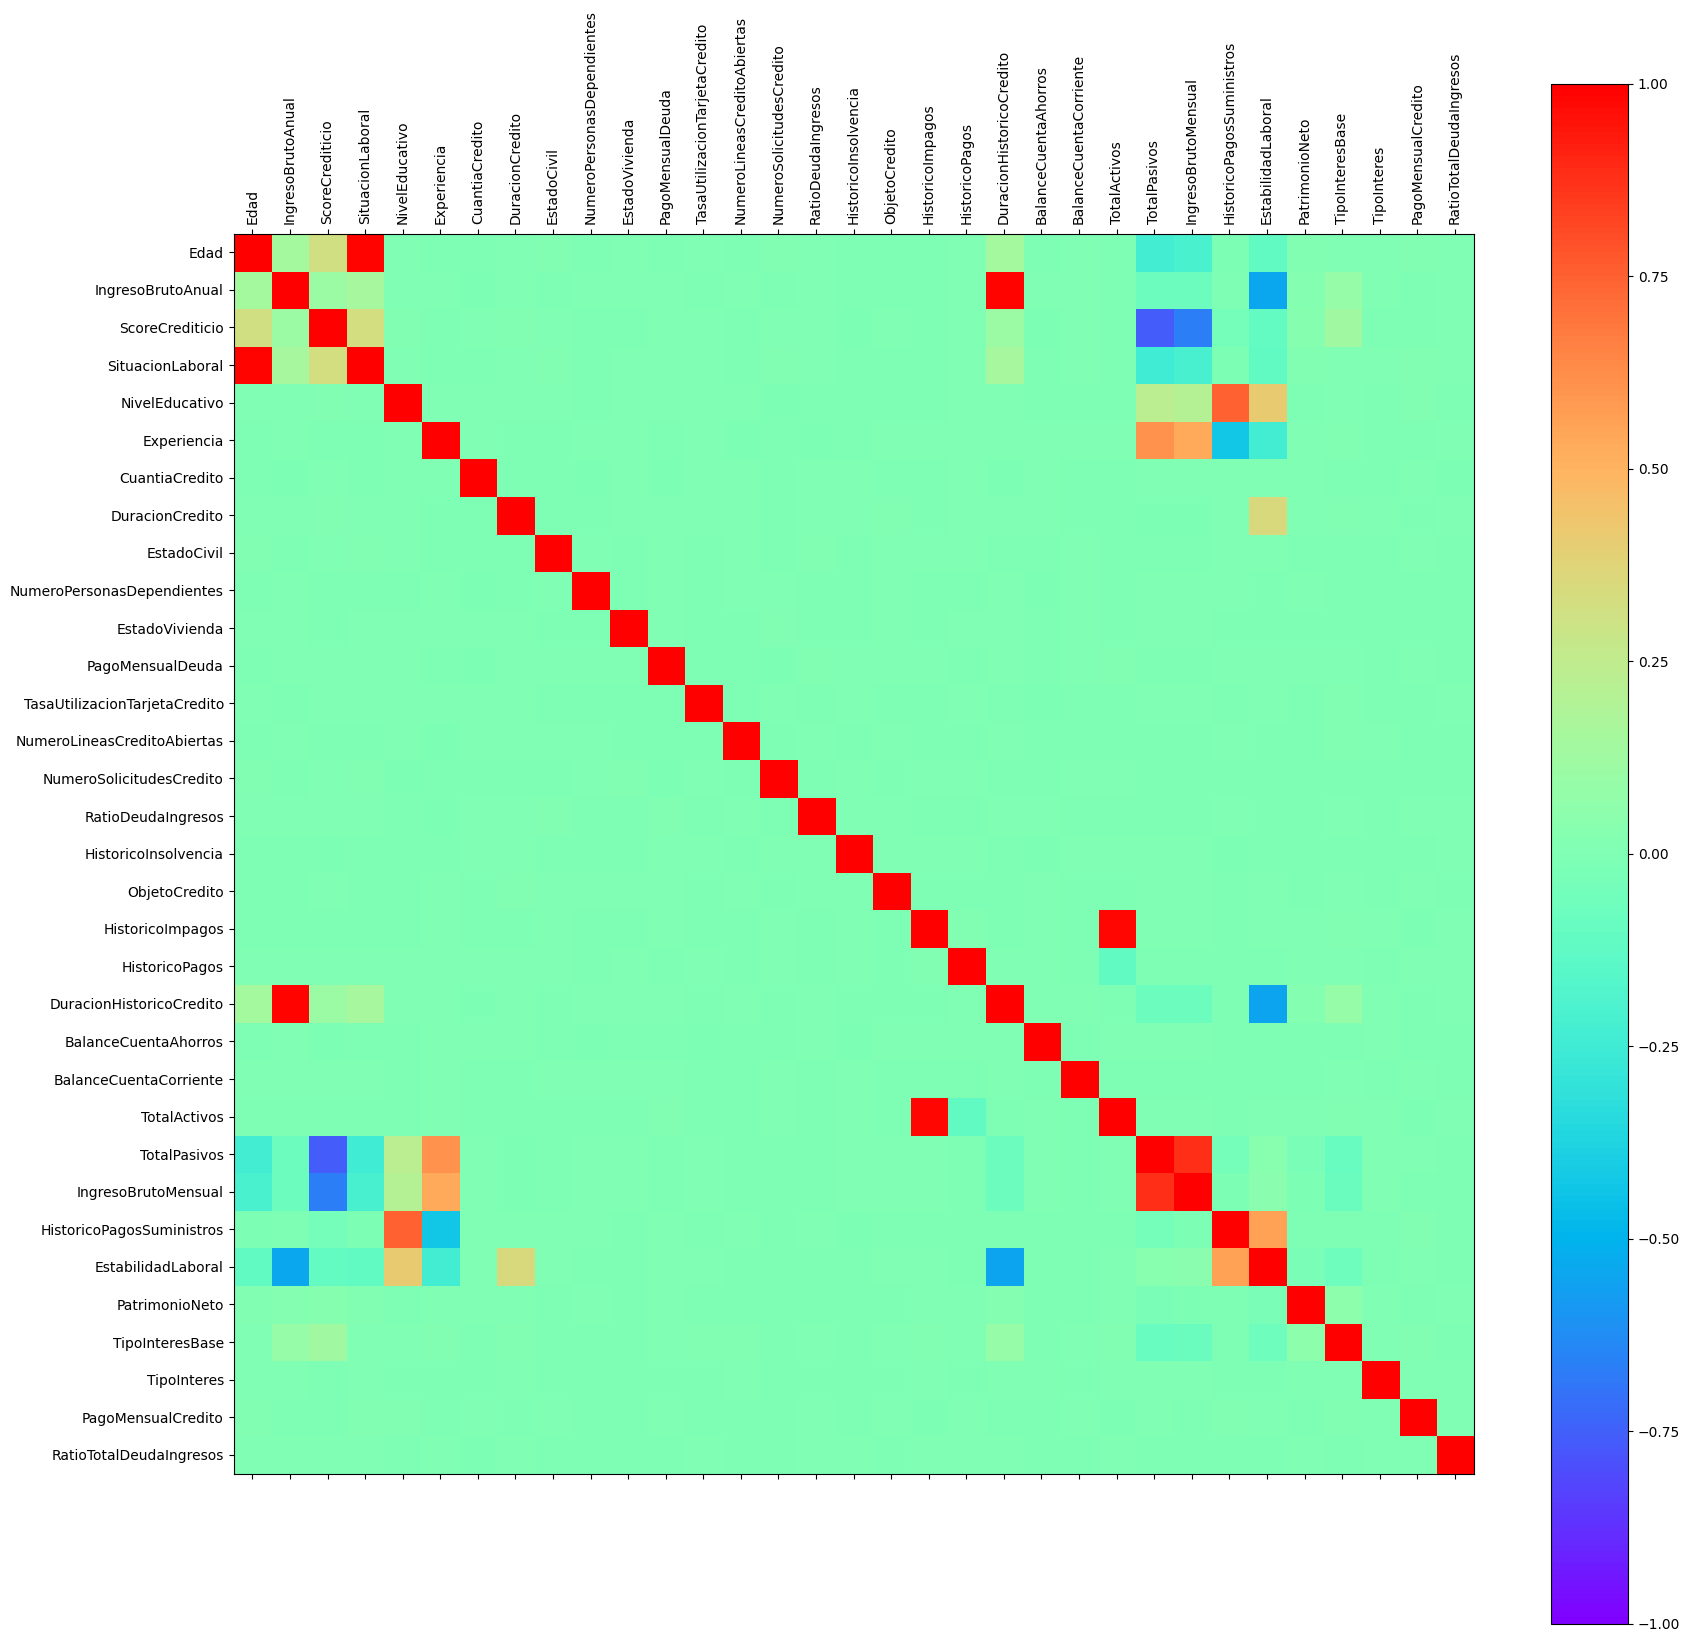

In [ ]:
import matplotlib.pyplot as plt
import category_encoders as ce

# Calculamos la matriz de correlaciones con la función corr de pandas sobre los datos de train
correlaciones = X_train_full.corr()

# Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.rainbow)
fig.colorbar(cax)
ticks = np.arange(0,len(X_train_full.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# Añadimos los nombres de las variables en la figura
names = X_train.columns
ax.set_xticklabels(names, rotation='vertical')
ax.set_yticklabels(names)
plt.show()



<ipython-input-15-8747f13640a0>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='correlation', y='pair', data=top_corr_pairs, palette=custom_palette[::-1])
<ipython-input-15-8747f13640a0>:16: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x='correlation', y='pair', data=top_corr_pairs, palette=custom_palette[::-1])


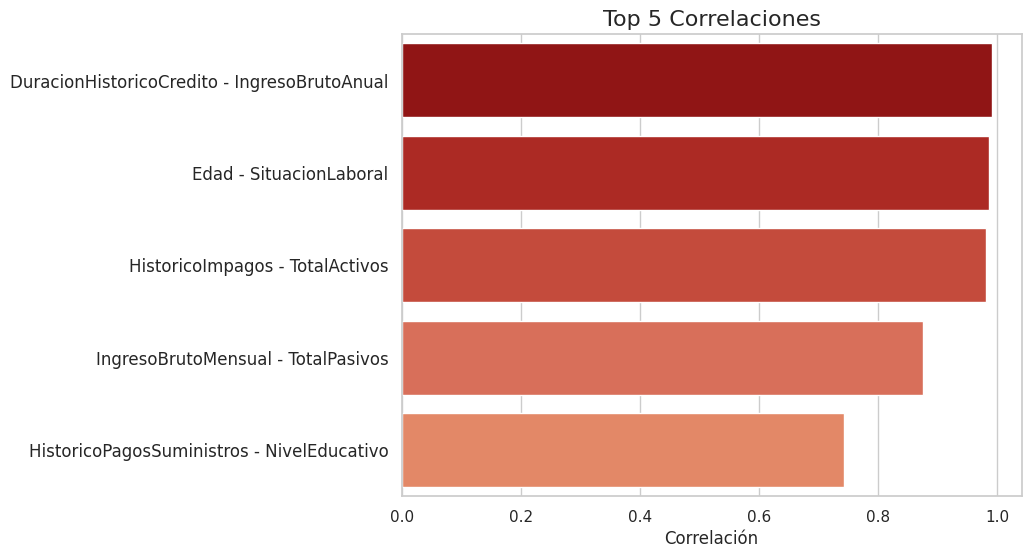

In [ ]:

corr_matrix = X_train_full.corr()

corr_pairs = corr_matrix.stack()
corr_pairs = corr_pairs.to_frame(name='correlation')

corr_pairs.reset_index(inplace=True)


corr_pairs = corr_pairs[(corr_pairs['level_0'] != corr_pairs['level_1']) & (corr_pairs['level_0'] < corr_pairs['level_1'])]
top_corr_pairs = corr_pairs.sort_values('correlation', ascending=False).head(5)
top_corr_pairs['pair'] = top_corr_pairs['level_0'] + ' - ' + top_corr_pairs['level_1']

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
custom_palette = sns.color_palette("OrRd", 10)
sns.barplot(x='correlation', y='pair', data=top_corr_pairs, palette=custom_palette[::-1])
plt.title('Top 5 Correlaciones', fontsize=16)
plt.xlabel('Correlación', fontsize=12)
plt.ylabel('')
plt.yticks(fontsize=12)
plt.show()

- En esta matriz de correlación vemos distintos pares de variables como, por ejemplo, *Edad* y *SituacionLaboral* que tienen un grado de relación muy alto (mayor al 0.95).

In [ ]:
from sklearn.base import TransformerMixin

# Creamos la clase de selección de variables en base a las correlaciones
class CorrSelection(TransformerMixin):

    # Constructor de la clase
    def __init__(self, umbral=0.95, verbose=False):
        # Umbral deseado para determinar variables correlacionadas
        self.umbral = umbral
        # Parámetro que determina si imprimir información del proceso o no
        self.verbose = verbose

    # Método fit
    def fit(self, X, y=None):
        # Transformamos X en DataFrame por si acaso llega en formato ndarray
        X = pd.DataFrame(X)
        # Calculamos la matriz de correlaciones con la función corr de pandas sobre el DataFrame con las variables de entrada X y la ponemos en valor absoluto
        correlaciones = X.corr().abs()
        # Seleccionamos el triángulo superior de la matriz de correlación
        upper = correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype('bool'))
        # Obtenemos los índices de aquellas variables con correlación mayor al umbral deseado
        self.indices_variables_a_eliminar = [i for i,column in enumerate(upper.columns) if any(upper[column] > self.umbral)]
         # Si queremos mostrar información se muestra el número de variables eliminadas y sus nombres
        if self.verbose:
            print('Se han eliminado {} variables, que son: '.format(len(self.indices_variables_a_eliminar)))
            print(list(X.columns[self.indices_variables_a_eliminar]))
        # Devolvemos el objeto modificado (en este caso ha aprendido qué variables se deben eliminar al estar correlacionadas con otras)
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X en DataFrame por si acaso llega en formato ndarray
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        X_uncorr = X.copy()
        # Eliminamos las variables con alta correlación con algunda de las variables de entrada
            # Usar los índices aprendidos para obtener la lista de variables a eliminar y elminarlas (método drop de Pandas)
        X_uncorr = X_uncorr.drop(columns = X.columns[self.indices_variables_a_eliminar], axis = 1)
        # Devolvemos el DataFrame transformado
        return X_uncorr

    # Método para asignar los valores de los híper-parámetros y que, de este modo,
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"umbral": self.umbral}

In [ ]:
corr = CorrSelection(umbral=0.95, verbose= True)
X_train_uncorr = corr.fit_transform(X_train_full)
X_test_uncorr = corr.transform(X_test_full)

Se han eliminado 3 variables, que son: 
['SituacionLaboral', 'DuracionHistoricoCredito', 'TotalActivos']


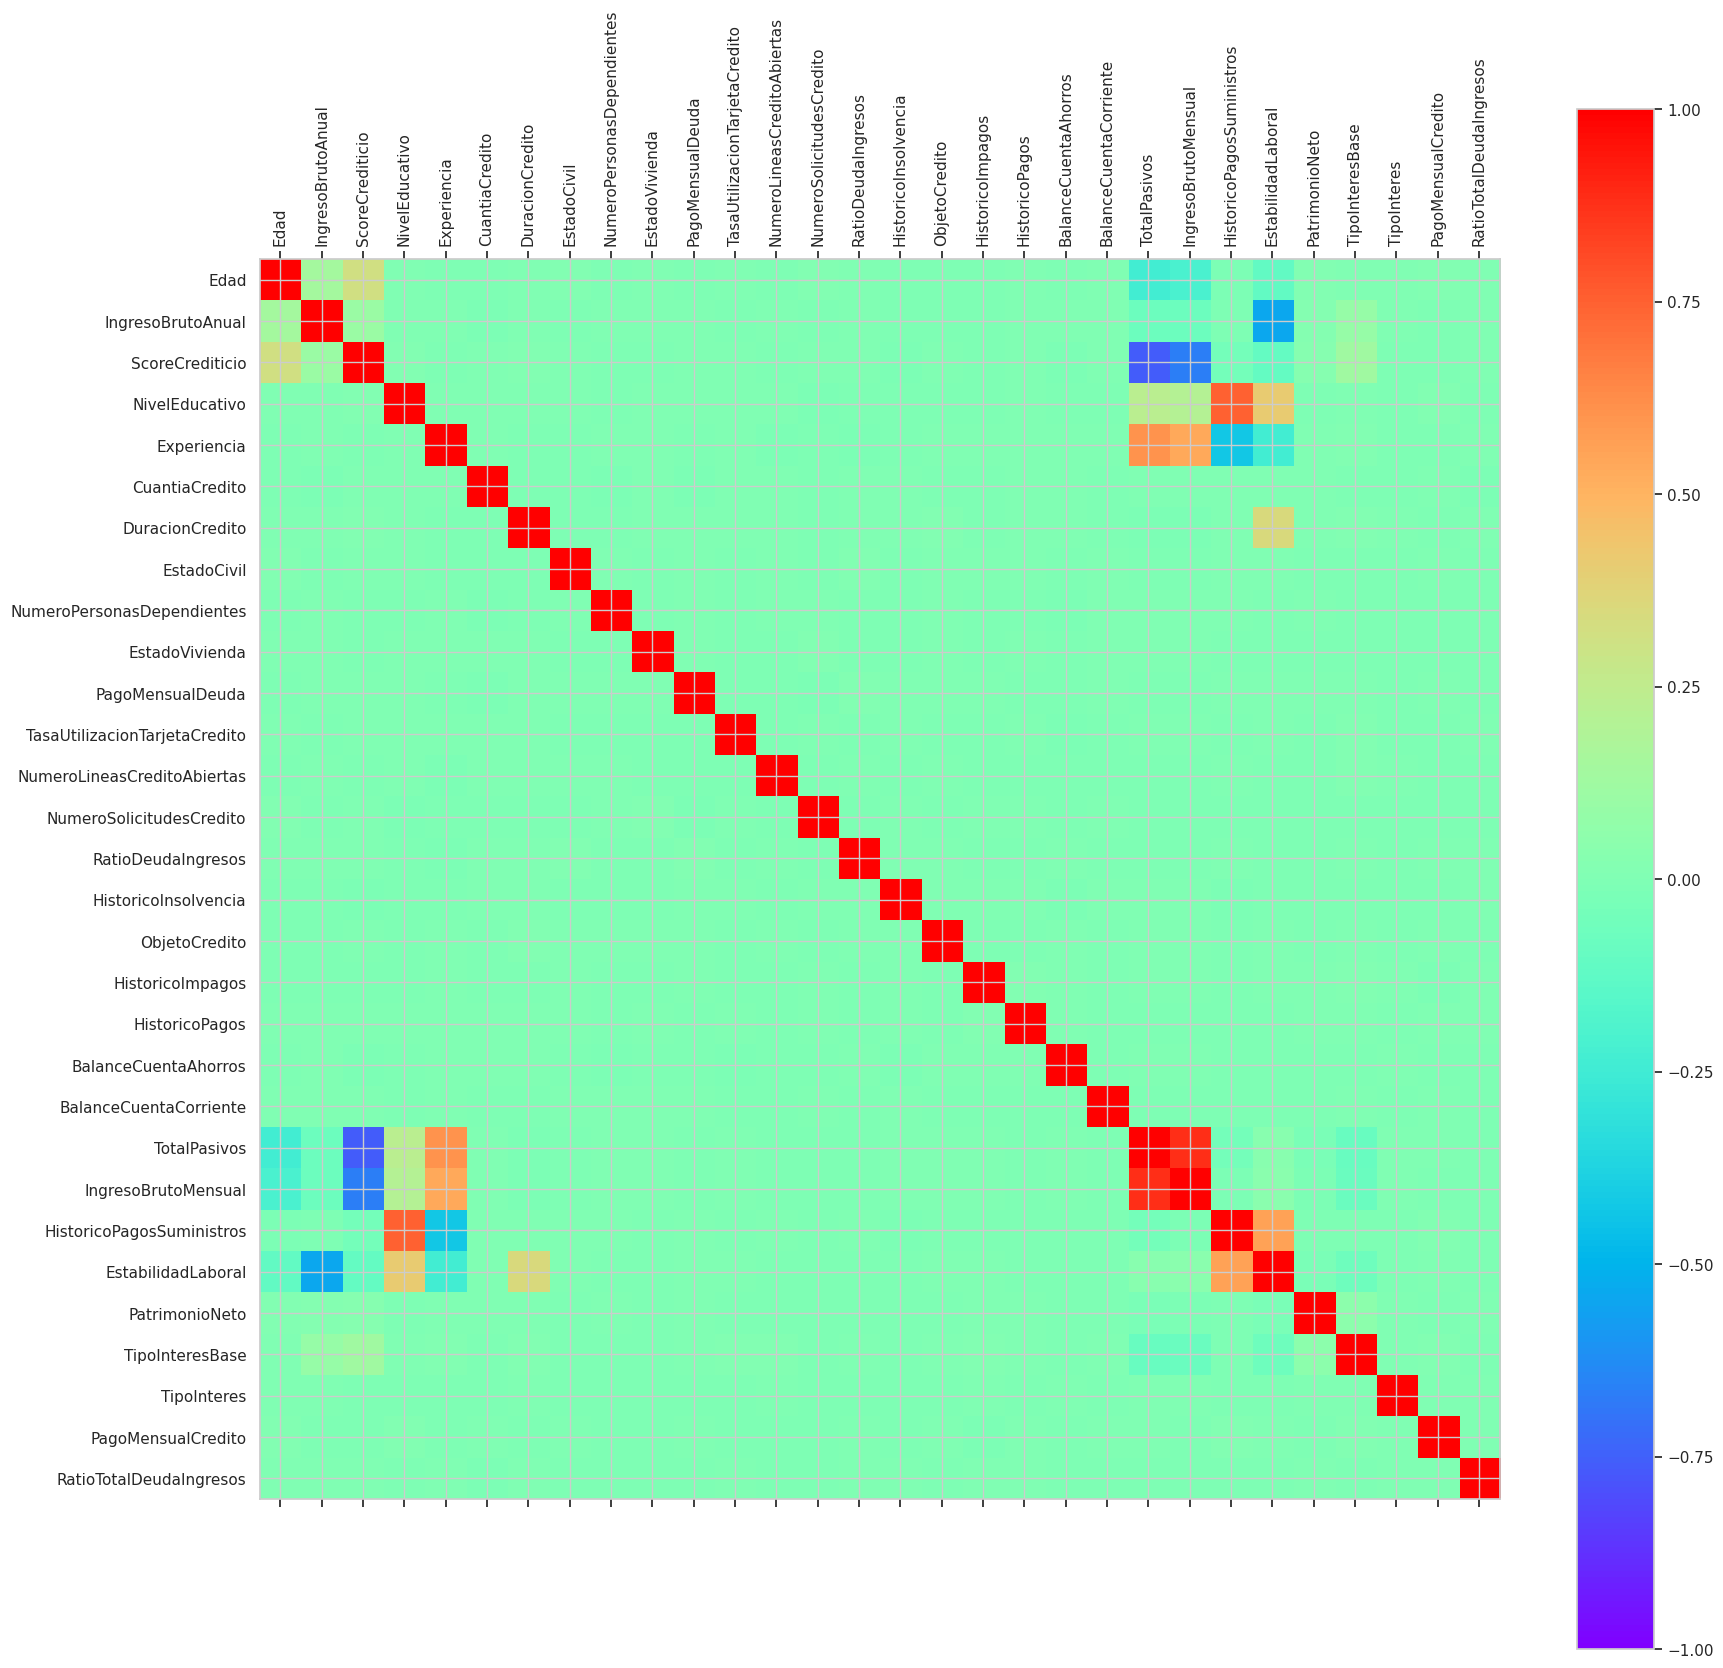

In [ ]:
# Calculamos la matriz de correlaciones con la función corr de pandas sobre los datos de train
correlaciones = X_train_uncorr.corr()

# Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.rainbow)
fig.colorbar(cax)
ticks = np.arange(0,len(X_train_uncorr.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# Añadimos los nombres de las variables en la figura
names = X_train_uncorr.columns
ax.set_xticklabels(names, rotation='vertical')
ax.set_yticklabels(names)
plt.show()

- Una vez se hayan eliminado las variables que se considera que aportan redundancia, vemos como en la matriz de correlación sin esas variables ya no hay relaciones entre variables mayores a 0.95, por lo que, dejamos el conjunto de datos como está.

## Normalización de datos

Se normalizan las características de los datos de entrenamiento y prueba utilizando `StandardScaler` para así poder evitar que algunas variables dominen sobre otras tan solo por tener rangos de valores distintos, además de que mejorar el rendimiento de los modelos.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_estandar = scaler.fit_transform(X_train_uncorr.to_numpy())
X_test_estandar = scaler.transform(X_test_uncorr.to_numpy())

## Modelos de Regresión

La función que se muestra en la siguiente celda, es la función que va a evaluar todos aquellos modelos que vamos a entrenar en el apartado de regresión mediante distintas métricas, aunque aquella métrica que va a ser más determinante es el *Error Absoluto Medio (MAE)*.

In [ ]:
# Función para evaluar el modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Métricas para modelo de {nombre_modelo}:")
    print(f"- Error Cuadrático Medio (MSE): {mse}")
    print(f"- Error Absoluto Medio (MAE): {mae}")
    print(f"- Raíz del Error Cuadrático Medio (RMSE): {rmse}")
    print(f"- Coeficiente de Determinación (R²): {r2}")
    print("\n")

### Regresión Lineal

In [ ]:
# Regresión Lineal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Crear el modelo de Regresión Lineal
model_lr = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
model_lr.fit(X_train_estandar, y_reg_train)

# Hacer predicciones con los datos de prueba
y_pred_lr = model_lr.predict(X_test_estandar)

# Evaluar el modelo
evaluar_modelo(y_reg_test, y_pred_lr, "Regresión Lineal")

Métricas para modelo de Regresión Lineal:
- Error Cuadrático Medio (MSE): 15.350289062205894
- Error Absoluto Medio (MAE): 3.2126951419524143
- Raíz del Error Cuadrático Medio (RMSE): 3.917944494528463
- Coeficiente de Determinación (R²): 0.762846783792954




Métricas para modelo de Regresión Lineal:
- Error Cuadrático Medio (MSE): 15.350289062205894
- Error Absoluto Medio (MAE): 3.2126951419524143
- Raíz del Error Cuadrático Medio (RMSE): 3.917944494528463
- Coeficiente de Determinación (R²): 0.762846783792954

### Regresión Ridge

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Definir los valores de alpha y otros parámetros que se quieren probar en Ridge
parametros_ridge = {
    'alpha': [0.1, 1, 10, 100, 1000, 10000, 50000, 100000],  # Valores más altos de alpha para mayor regularización
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'],  # Solvers disponibles
    'fit_intercept': [True, False],  # Intercepto
    'tol': [0.0001, 0.001, 0.01],  # Tolerancias
    'max_iter': [100, 1000, 5000],  # Iteraciones
}

# Crear el modelo de Regresión Ridge
model_ridge = Ridge()

# Usar GridSearchCV para encontrar la mejor combinación de parámetros
grid_search_ridge = GridSearchCV(estimator=model_ridge, param_grid=parametros_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_estandar, y_reg_train)

# Obtener el mejor modelo de Ridge y los mejores parámetros
best_ridge = grid_search_ridge.best_estimator_
mejores_parametros = grid_search_ridge.best_params_

print(f"Mejores parámetros encontrados por GridSearch: {mejores_parametros}")

# Hacer predicciones con el mejor modelo de Ridge
y_pred_ridge = best_ridge.predict(X_test_estandar)

# Evaluar el modelo de Ridge con los mejores parámetros
evaluar_modelo(y_reg_test, y_pred_ridge, "Regresión Ridge")


Mejores parámetros encontrados por GridSearch: {'alpha': 10, 'fit_intercept': True, 'max_iter': 100, 'solver': 'saga', 'tol': 0.01}
Métricas para modelo de Regresión Ridge:
- Error Cuadrático Medio (MSE): 15.336814087279798
- Error Absoluto Medio (MAE): 3.211393945908427
- Raíz del Error Cuadrático Medio (RMSE): 3.9162244684491463
- Coeficiente de Determinación (R²): 0.7630549644747042




Mejores parámetros encontrados por GridSearch: {'alpha': 10, 'fit_intercept': True, 'max_iter': 100, 'solver': 'saga', 'tol': 0.01}
Métricas para modelo de Regresión Ridge:
- Error Cuadrático Medio (MSE): 15.336814087279798
- Error Absoluto Medio (MAE): 3.211393945908427
- Raíz del Error Cuadrático Medio (RMSE): 3.9162244684491463
- Coeficiente de Determinación (R²): 0.7630549644747042

In [ ]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha = 1, fit_intercept = True, max_iter = 100, solver = 'saga', tol = 0.01)
model_ridge.fit(X_train_estandar, y_reg_train)

y_pred_ridge = model_ridge.predict(X_test_estandar)
evaluar_modelo(y_reg_test, y_pred_ridge, "Regresión Ridge")

Métricas para modelo de Regresión Ridge:
- Error Cuadrático Medio (MSE): 15.341234652779548
- Error Absoluto Medio (MAE): 3.211417392986976
- Raíz del Error Cuadrático Medio (RMSE): 3.9167888190173783
- Coeficiente de Determinación (R²): 0.7629866692574956




### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2)     <-- ¡¡Mejores parámetros con GridSearch!!
model_rf = RandomForestRegressor()
# Definir los hiperparámetros a probar
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 10]
}

# Crear GridSearchCV
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=5, n_jobs = -1, scoring='neg_mean_squared_error')
# Ajustar el modelo con los datos
grid_search_rf.fit(X_train_estandar, y_reg_train)

KeyboardInterrupt: 

In [ ]:
# Obtener mejor Random Forest
best_rf = grid_search_rf.best_estimator_
# Obtener los mejores hiperparámetros
mejores_parametros_rf = grid_search_rf.best_params_
print("Mejores hiperparámetros:", mejores_parametros_rf)
# Hacer predicciones con el mejor modelo de Random Forest
y_pred_rf = best_rf.predict(X_test_estandar)

# Evaluar el Random Forest con los mejores parámetros
evaluar_modelo(y_reg_test, y_pred_rf, "Random Forest")

In [ ]:
# RANDOM FOREST CON MEJORES PARÁMETROS

from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2)

model_rf.fit(X_train_estandar, y_reg_train)

y_pred_rf = model_rf.predict(X_test_estandar)

evaluar_modelo(y_reg_test, y_pred_rf, "Random Forest")

Métricas para modelo de Random Forest:
- Error Cuadrático Medio (MSE): 8.287331277966647
- Error Absoluto Medio (MAE): 1.7849129285153114
- Raíz del Error Cuadrático Medio (RMSE): 2.8787725297367013
- Coeficiente de Determinación (R²): 0.8719654556094327




n_estimators=200, max_depth=20, min_samples_split=2

Métricas para modelo de Random Forest:
- Error Cuadrático Medio (MSE): 8.287331277966647
- Error Absoluto Medio (MAE): 1.7849129285153114
- Raíz del Error Cuadrático Medio (RMSE): 2.8787725297367013
- Coeficiente de Determinación (R²): 0.8719654556094327

## XGBoost Regressor

In [ ]:
xgb_reg = xgb.XGBRegressor()

# parámetros OBTENIDOS EN GRID SEARCH
xgb_reg.n_jobs = -1  # siempre así
xgb_reg.eval_metric = 'mae'
xgb_reg.learning_rate = 0.05
xgb_reg.max_depth = 9
xgb_reg.n_estimators = 500
xgb_reg.subsample = 0.6

xgb_reg.fit(X_train_estandar, y_reg_train)

y_pred_xgb = xgb_reg.predict(X_test_estandar)

# Evaluar el modelo de xgboost con test
evaluar_modelo(y_reg_test, y_pred_xgb, "XGBoost")

Métricas para modelo de XGBoost:
- Error Cuadrático Medio (MSE): 6.126182566380236
- Error Absoluto Medio (MAE): 1.5802866572570797
- Raíz del Error Cuadrático Medio (RMSE): 2.4751126371097207
- Coeficiente de Determinación (R²): 0.9053539713290697




Métricas para modelo de XGBoost:
- Error Cuadrático Medio (MSE): 6.126182566380236
- Error Absoluto Medio (MAE): 1.5802866572570797
- Raíz del Error Cuadrático Medio (RMSE): 2.4751126371097207
- Coeficiente de Determinación (R²): 0.9053539713290697

### Red neuronal

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Establecemos distintos hyperparametros para probar
param_grid = {
    'hidden_layer_sizes': [(67,), (68,), (71,), (73,)],
    'activation': [ 'tanh'],
    'solver': ['sgd'],
    'alpha': [0.0001],
}

# Crear el modelo base
base_model = MLPRegressor(random_state=100)

# Realizar la búsqueda exhaustiva
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_estandar, y_reg_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print(best_model)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted

In [ ]:
# MEJORES PARÁMETROS: activation='tanh', hidden_layer_sizes=(71,), solver='sgd'

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(activation='tanh', hidden_layer_sizes=(71,), random_state=100,
             solver='sgd')

mlp.fit(X_train_estandar, y_reg_train)

evaluar_modelo(y_reg_test, mlp.predict(X_test_estandar), "Red Neuronal")

Métricas para modelo de Red Neuronal:
- Error Cuadrático Medio (MSE): 5.213471145428674
- Error Absoluto Medio (MAE): 1.4459751058423582
- Raíz del Error Cuadrático Medio (RMSE): 2.2833026837081136
- Coeficiente de Determinación (R²): 0.9194548425289806




Métricas para modelo de Red Neuronal:
- Error Cuadrático Medio (MSE): 5.213471145428674
- Error Absoluto Medio (MAE): 1.4459751058423582
- Raíz del Error Cuadrático Medio (RMSE): 2.2833026837081136
- Coeficiente de Determinación (R²): 0.9194548425289806

### Ensemble Stacking

### Stacking con LinearRegressor

In [ ]:
# Con linearRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Definir modelos base y parámetros
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2)),
    ('mlp',MLPRegressor(activation='tanh', hidden_layer_sizes=(71,), random_state=100, solver='sgd')),
    ('xgb', xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, subsample=0.5, eval_metric='rmse'))
]

# Definir meta-model
meta_model_lr = LinearRegression()

# Crear modelo de stacking
stack_model_lr = StackingRegressor(estimators=base_models, final_estimator=meta_model_lr)

# Entrenar
stack_model_lr.fit(X_train_estandar, y_reg_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=20,
                                                     n_estimators=200)),
                              ('mlp',
                               MLPRegressor(activation='tanh',
                                            hidden_layer_sizes=(71,),
                                            random_state=100, solver='sgd')),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression())

In [ ]:
y_pred_stack_lr = stack_model_lr.predict(X_test_estandar)
# Evaluar el modelo
evaluar_modelo(y_reg_test, y_pred_stack_lr, "Stacking Regressor LR")

Métricas para modelo de Stacking Regressor LR:
- Error Cuadrático Medio (MSE): 5.064445112312305
- Error Absoluto Medio (MAE): 1.4223908841216104
- Raíz del Error Cuadrático Medio (RMSE): 2.2504322056690143
- Coeficiente de Determinación (R²): 0.9217572097944374




Métricas para modelo de Stacking Regressor LR:
- Error Cuadrático Medio (MSE): 5.064445112312305
- Error Absoluto Medio (MAE): 1.4223908841216104
- Raíz del Error Cuadrático Medio (RMSE): 2.2504322056690143
- Coeficiente de Determinación (R²): 0.9217572097944374

### Stacking con GradientBoost

In [ ]:
# Con Gradient BoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# Definir modelos base y parámetros
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2)),
    ('mlp',MLPRegressor(activation='tanh', hidden_layer_sizes=(71,), random_state=100, solver='sgd')),
    ('xgb', xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, subsample=0.5, eval_metric='rmse'))
]

# Definir meta-model
meta_model_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)

# Crear modelo de stacking
stack_model_gbr = StackingRegressor(estimators=base_models, final_estimator=meta_model_gbr)

# Entrenar
stack_model_gbr.fit(X_train_estandar, y_reg_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=20,
                                                     n_estimators=200)),
                              ('mlp',
                               MLPRegressor(activation='tanh',
                                            hidden_layer_sizes=(71,),
                                            random_state=100, solver='sgd')),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=...
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=GradientBoostingRegressor())

In [ ]:
y_pred_stack_gbr = stack_model_gbr.predict(X_test_estandar)
# Evaluar el modelo
evaluar_modelo(y_reg_test, y_pred_stack_gbr, "Stacking Regressor GBR")

Métricas para modelo de Stacking Regressor GBR:
- Error Cuadrático Medio (MSE): 5.016092119039875
- Error Absoluto Medio (MAE): 1.384663737918208
- Raíz del Error Cuadrático Medio (RMSE): 2.2396633941375823
- Coeficiente de Determinación (R²): 0.9225042359788517




Métricas para modelo de Stacking Regressor GBR:
- Error Cuadrático Medio (MSE): 5.007619941188237
- Error Absoluto Medio (MAE): 1.3818618106688285
- Raíz del Error Cuadrático Medio (RMSE): 2.2377711994724208
- Coeficiente de Determinación (R²): 0.9226351262974412

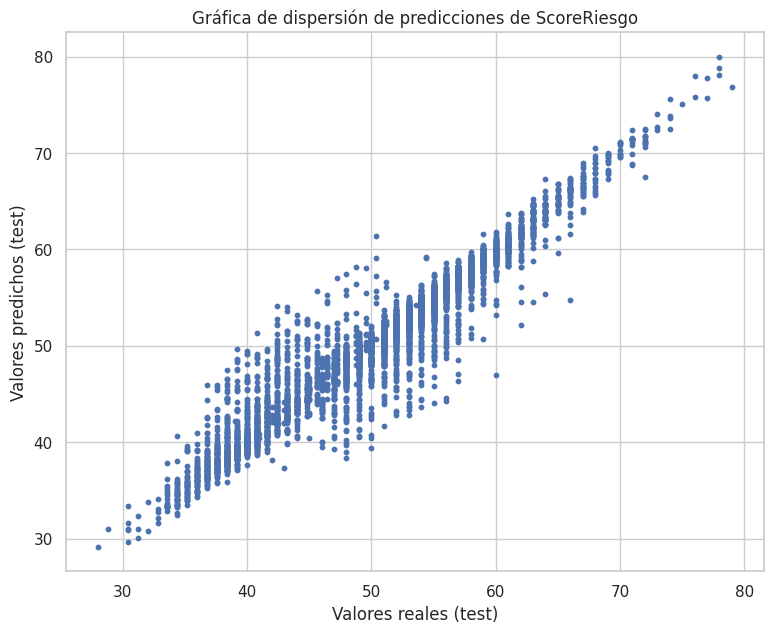

In [ ]:
# Crear la gráfica de dispersión

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 7))

plt.scatter(y_reg_test, y_pred_stack_gbr, s=10)
plt.title('Gráfica de dispersión de predicciones de ScoreRiesgo')
plt.xlabel('Valores reales (test)')
plt.ylabel('Valores predichos (test)')
plt.grid(True)

plt.savefig('dispersion_regresion.png', dpi=800)

plt.show()

## Modelos Clasificación

Por último, se van a entrenar distintos modelos de clasificación con el fin de obtener un modelo que sea capaz de clasificar la variable *CreditoAprobado*

La función que se muestra en la siguiente celda, es la función que va a evaluar todos aquellos modelos que vamos a entrenar en clasificación mediante distintas métricas, aunque aquella métrica que va a ser más determinante es el *AUC*.



In [ ]:
# FUNCIÓN EVALUACIÓN

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Función para evaluar el modelo de clasificación
def evaluar_modelo_clasif(y_true, y_pred, prob_pred=None, nombre_modelo=None):
    # Calcular Accuracy y F1-Score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Métricas para el modelo {nombre_modelo if nombre_modelo else ''}:")
    print(f"- Accuracy: {accuracy}")
    print(f"- F1-Score: {f1}")

    # Si se proporcionan las probabilidades, calcular el ROC AUC
    if prob_pred is not None:
        try:
            roc_auc = roc_auc_score(y_true, prob_pred)
            print(f"- ROC AUC: {roc_auc}")
        except ValueError:
            print("No se pudo calcular ROC AUC. Asegúrate de proporcionar probabilidades")
    print("\n")

# Ejemplo de uso:
# y_true -> etiquetas verdaderas
# y_pred -> etiquetas predichas
# prob_pred -> probabilidades de predicción del modelo (opcional)

In [ ]:
# DIBUJAR CURVA ROC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Función para graficar la curva ROC
def graficar_curva_roc(y_true, prob_pred, nombre_modelo=None):
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, prob_pred)

    # Calcular el área bajo la curva (AUC)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')

    plt.xlim([-0.001, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos (FPR)')
    plt.ylabel('Tasa de verdaderos positivos (TPR)')
    plt.title(f'Curva ROC para {nombre_modelo if nombre_modelo else "el modelo"}')
    plt.legend(loc="lower right")

    plt.savefig(f'curvaROC_{nombre_modelo}.png', dpi=800)

    plt.show()

# Ejemplo de uso:
# y_true -> etiquetas verdaderas
# prob_pred -> probabilidades de la clase positiva

### SVM

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm

C_values = [0.25, 0.5, 0.1, 1]
kernel = ['linear', 'rbf']
gamma = ['scale', 'auto']
param_grid =  {'C': C_values, 'kernel' : kernel, 'gamma' : gamma}

skf = StratifiedKFold(n_splits=5)
# Genera el diccionario param_grid con los valores indicados

clasificadores = GridSearchCV(svm.SVC(), param_grid, n_jobs = -1 , cv = skf, scoring = 'f1', verbose = 4)
clasificadores.fit(X_train_estandar, y_clf_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 0.1, 1], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='f1', verbose=4)

In [ ]:
from sklearn.metrics import f1_score

C_best = clasificadores.best_params_["C"]
kernel_best = clasificadores.best_params_["kernel"]
gamma_best = clasificadores.best_params_["gamma"]

print("Mejores parámetros C: {}, kernel: {}, gamma: {}".format(C_best, kernel_best, gamma_best))
print("Score obtenido en train: ", clasificadores.best_score_, "\n")

best = clasificadores.best_estimator_

Mejores parámetros C: 1, kernel: rbf, gamma: scale
Score obtenido en train:  0.9061453025938455 



In [ ]:
# CON MEJORES PARÁMETROS: C=1, kernel='rbf', gamma='scale', probability=True
model_svm = svm.SVC(C=1, kernel='rbf', gamma='scale', probability=True)

model_svm.fit(X_train_estandar, y_clf_train)

y_pred_svm_clf = model_svm.predict(X_test_estandar)
y_prob_svm_clf = model_svm.predict_proba(X_test_estandar)[:, 1]

evaluar_modelo_clasif(y_clf_test, y_pred_svm_clf, y_prob_svm_clf, "SVM Classifier")

Métricas para el modelo SVM Classifier:
- Accuracy: 0.9452
- F1-Score: 0.9048611111111111
- ROC AUC: 0.9879953922565512




### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definir los valores para los parámetros del MLP
hidden_layer_sizes = [ (16, 64, 96, 48,), (32, 64, 128,), (128, ), (156,)]
activation = ['tanh', 'relu']
solver = ['adam', 'sgd']

# Generar el diccionario param_grid con los valores indicados
param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': activation,
    'solver': solver
}

# Definir la validación cruzada estratificada
skf = StratifiedKFold(n_splits=5)

# GridSearchCV con MLPClassifier
clasificadores = GridSearchCV(MLPClassifier(max_iter=2000), param_grid, n_jobs=-1, cv=skf, scoring='f1', verbose=4)

# Entrenar el modelo con los datos de entrenamiento estandarizados
clasificadores.fit(X_train_estandar, y_clf_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MLPClassifier(max_iter=2000), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(16, 64, 96, 48), (32, 64, 128),
                                                (128,), (156,)],
                         'solver': ['adam', 'sgd']},
             scoring='f1', verbose=4)

In [ ]:
# Obtener los mejores parámetros tras el GridSearchCV
hidden_layer_best = clasificadores.best_params_["hidden_layer_sizes"]
activation_best = clasificadores.best_params_["activation"]
solver_best = clasificadores.best_params_["solver"]

# Imprimir los mejores parámetros
print("Mejores parámetros hidden_layer_sizes: {},  activation: {}, solver: {}".format(
    hidden_layer_best,  activation_best, solver_best))

print("Score obtenido en train: ", clasificadores.best_score_)

best = clasificadores.best_estimator_

y_pred_mlp_clf = best.predict(X_test_estandar)
y_prob_mlp_clf = best.predict_proba(X_test_estandar)[:, 1]

evaluar_modelo_clasif(y_clf_test, y_pred_mlp_clf, y_prob_mlp_clf, "MLP Classifier")

Mejores parámetros hidden_layer_sizes: (32, 64, 128),  activation: tanh, solver: sgd
Score obtenido en train:  0.912472990851593
Métricas para el modelo MLP Regressor:
- Accuracy: 0.9474
- F1-Score: 0.9094040647605925
- ROC AUC: 0.9894551930148832




Mejores parámetros hidden_layer_sizes: (32, 64, 128),  activation: tanh, solver: sgd
Score obtenido en train:  0.912472990851593
Métricas para el modelo MLP Classifier:
- Accuracy: 0.9474
- F1-Score: 0.9094040647605925
- ROC AUC: 0.9894551930148832

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definir los valores para los parámetros de la regresión logística
C_values = [0.25, 0.5, 1, 10, 15, 30]
penalty = ['l1', 'l2']  # Tipo de penalización
solver = ['liblinear', 'saga']  # Solvers que soportan 'l1' y 'l2'

# Generar el diccionario param_grid con los valores indicados
param_grid =  {'C': C_values, 'penalty': penalty, 'solver': solver}

# Definir la validación cruzada estratificada
skf = StratifiedKFold(n_splits=5)

# GridSearchCV con LogisticRegression
clasificadores = GridSearchCV(LogisticRegression(max_iter=100000), param_grid, n_jobs=-1, cv=skf, scoring='f1', verbose=4)

# Entrenar el modelo con los datos de entrenamiento estandarizados
clasificadores.fit(X_train_estandar, y_clf_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=100000), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 1, 10, 15, 30],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1', verbose=4)

In [ ]:
# Obtener los mejores parámetros tras el GridSearchCV
C_best = clasificadores.best_params_["C"]
penalty_best = clasificadores.best_params_["penalty"]
solver_best = clasificadores.best_params_["solver"]

# Imprimir los mejores parámetros
print("Mejores parámetros C: {}, penalty: {}, solver: {}".format(C_best, penalty_best, solver_best))

print("Score obtenido en train: ", clasificadores.best_score_)

best = clasificadores.best_estimator_

y_pred_log_clf = best.predict(X_test_estandar)
y_prob_log_clf = best.predict_proba(X_test_estandar)[:, 1]

evaluar_modelo_clasif(y_clf_test, y_pred_log_clf, y_prob_log_clf, "Logistic Regression Classifier")


Mejores parámetros C: 1, penalty: l1, solver: liblinear
Score obtenido en train:  0.8995943360916414
Métricas para el modelo Logistic Regression Classifier:
- Accuracy: 0.941
- F1-Score: 0.8981001727115717
- ROC AUC: 0.9871905040954718




Mejores parámetros C: 1, penalty: l1, solver: liblinear
Score obtenido en train:  0.8995943360916414
Métricas para el modelo Logistic Regression Classifier:
- Accuracy: 0.941
- F1-Score: 0.8981001727115717
- ROC AUC: 0.9871905040954718

### AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Definimos el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de estimadores (número de árboles débiles)
    'learning_rate': [0.01, 0.1, 1.0],  # Tasa de aprendizaje
    'estimator__max_depth': [1, 2, 3],  # Profundidad máxima del árbol base
    'estimator__min_samples_split': [2, 5, 10]  # Muestras mínimas para dividir un nodo
}

# Inicializamos el GridSearchCV
clasificadores = GridSearchCV(estimator=ada, param_grid=param_grid,
                           scoring='f1', cv=skf, verbose=2, n_jobs=-1)
clasificadores.fit(X_train_estandar, y_clf_train)

In [ ]:
n_estimators_best = clasificadores.best_params_["n_estimators"]
learning_rate_best = clasificadores.best_params_["learning_rate"]
max_depth_best = clasificadores.best_params_["estimator__max_depth"]
min_samples_split_best = clasificadores.best_params_["estimator__min_samples_split"]

# Imprimir los mejores parámetros
print("Mejores parámetros n_estimators: {}, learning_rate: {}, max_depth: {}, min_samples_split: {}".format(
    n_estimators_best, learning_rate_best, max_depth_best, min_samples_split_best))

# Score obtenido en el conjunto de entrenamiento durante GridSearchCV
print("Score obtenido en train: {:.4f}".format(clasificadores.best_score_))

# Predecir con el mejor modelo encontrado
best_model = clasificadores.best_estimator_

In [ ]:
# usando los mejores parámetros: n_estimators=200, learning_rate=1.0, max_depth=1, min_samples_split=2

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=1, min_samples_split=2)
model_ada = AdaBoostClassifier(n_estimators=200, learning_rate=1.0, random_state=133)

model_ada.fit(X_train_estandar, y_clf_train)

y_pred_ada_clf = model_ada.predict(X_test_estandar)
y_prob_ada_clf = model_ada.predict_proba(X_test_estandar)[:, 1]

evaluar_modelo_clasif(y_clf_test, y_pred_ada_clf, y_prob_ada_clf, "AdaBoost Classifier")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Métricas para el modelo AdaBoost Classifier:
- Accuracy: 0.949
- F1-Score: 0.9127011297500855
- ROC AUC: 0.9902218634647173




Métricas para el modelo AdaBoost Classifier:
- Accuracy: 0.949
- F1-Score: 0.9127011297500855
- ROC AUC: 0.9902218634647173

### Random Forest CLF

In [ ]:
# GRID SEARCH

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# n_estimators indica el número de árboles del bosque
rf = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1')

# Ajustar el GridSearchCV a los datos
grid_search.fit(X_train_estandar, y_clf_train)

# Obtener los mejores parámetros y el mejor estimador
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_model)
print(best_params)


In [ ]:
# CON MEJORES PARÁMETROS: n_estimators=300, max_depth = 15, min_samples_leaf = 1

from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

rf_clasif = RandomForestClassifier(n_estimators=300, max_depth = 15, min_samples_leaf = 1, random_state=133)
rf_clasif.fit(X_train_estandar, y_clf_train)

y_pred_rf_clf = rf_clasif.predict(X_test_estandar)
y_prob_rf_clf = rf_clasif.predict_proba(X_test_estandar)[:, 1]

evaluar_modelo_clasif(y_clf_test, y_pred_rf_clf, y_prob_rf_clf, "Random Forest Classifier")

Métricas para el modelo Random Forest Classifier:
- Accuracy: 0.9154
- F1-Score: 0.8505828329212293
- ROC AUC: 0.9749297604791807




n_estimators=300, max_depth=15, min_samples_leaf=1
Métricas para el modelo Random Forest Classifier:
- Accuracy: 0.9154
- F1-Score: 0.8505828329212293
- ROC AUC: 0.9749297604791807

### XGBoost Classifier

Métricas para el modelo XGBoost Classifier:
- Accuracy: 0.9504
- F1-Score: 0.9146005509641874
- ROC AUC: 0.9905999871835554




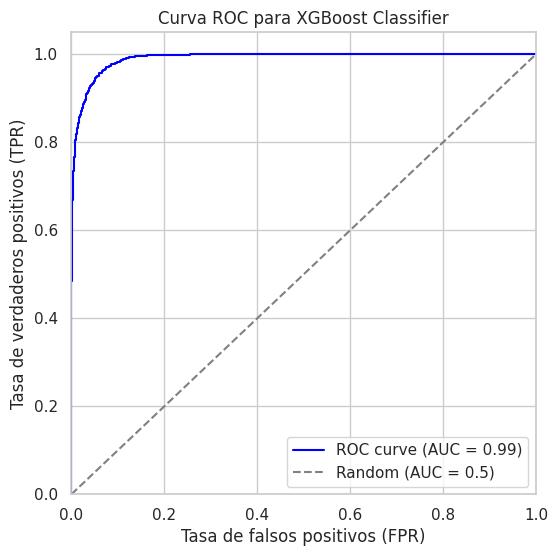

In [ ]:
# usar mejores parámetros

import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_jobs=-1,
    learning_rate=0.07,
    max_depth=5,
    subsample=0.7,
    n_estimators=500,
    eval_metric='logloss'  # Para clasificación
)

xgb_clf.fit(X_train_estandar, y_clf_train)

y_pred_xgb_clf = xgb_clf.predict(X_test_estandar)

y_prob_xgb_clf = xgb_clf.predict_proba(X_test_estandar)[:, 1]  # Probabilidades de predicción

# Evaluar el modelo usando tanto las etiquetas predichas como las probabilidades
evaluar_modelo_clasif(y_clf_test, y_pred_xgb_clf, y_prob_xgb_clf, "XGBoost Classifier")

# graficar curva roc
graficar_curva_roc(y_clf_test, y_prob_xgb_clf, "XGBoost Classifier")